# Predicting migration phases in eagles:  an exercise in Basemap, Pandas, 3D Plotting, and unsupervised Machine Learning

This post is based on a project I had for my machine learning class. My team (myself, Roman Sarrazin Gendron, and Navin Mordani) were asked to obtain a dataset from the animal migrations databank [movebank](www.movebank.org) and build some model that can help conservation efforts. We chose to look at migration patterns of eagles and other predatory birds and predict their migration start and end times as a function of temperature. The first step is to be able to determine when a bird is undergoing a migration and when the bird is at a homebase. Because our dataset only contains recorded times and positions, we would have to do some unsupervised learning to identify migratory phases. We took a very naïve approach to this problem so ecologists and biologists will have to take this with a huge grain of salt. The main purpose of this post is to illustrate some nice Python modules, do some basic machine learning and make some pretty plots.

With this post, you'll learn a bit about how to use Python's map plotting library `Basemap`, managing datasets with `Pandas`, 3D plotting, and basic unsupervised machine learning. 

## The Data

We assembled a dataset (curated by Roman Sarrazin Gendron) that contains times and positions of 14 species around the world. In order to make this simpler if you want to follow along, I included a condensed version of the dataset since it is very large. Here's the command in pandas I used to generate the condensed dataset. The condensed data is stored in a file called `eagles_small.csv` in this notebook's directory. Let's assume that the original data is in a file called `eagles.csv`.

``` python
import pandas as pd
df = pd.read_csv('eagles.csv')
df2 = df.sample(frac=0.1)
df2.to_csv('eagles_small.csv')
```

Ok so to start we're going to have to import a couple of things. 

In [71]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from sklearn.cluster import KMeans
import seaborn as sns
import math
from scipy.spatial.distance import mahalanobis

%matplotlib inline

sns.set_style(style="white")
plt.rcParams['figure.figsize'] = 14, 12


Using `Pandas` we can easily load data from text files in various formats. In our case, the data is in `csv` format. Here, data is stored in rows with entries separated by columns. The first row is typically known as the header row and it contains labels for each of its corresponding columns. Pandas automatically reads these labels and lets you access the data by label when you load it. Let's load the `eagles_small.csv` data into the main `Pandas` data structure known as a `DataFrame`.

In [6]:
df = pd.read_csv('../Data/eagles_short.csv')
#head() will print the first couple of lines of the DataFrame
df.head()

,Unnamed: 0,timeofyear,long,lat,species,fulldate,tag
0,455810,0.857534,21.654294,15.956181,Ciconia nigra,2015-11-09 13:50:09.000,2699
1,1314661,0.139726,90.367971,27.600898,Gyps himalayensis,2015-02-20 22:00:06.000,3932
2,764593,0.336986,87.284953,28.744269,Gyps himalayensis,2015-05-03 08:48:05.000,4003
3,1597617,0.418033,0.723650,42.564186,Aquila clanga,2016-06-01 11:40:19.000,15005
4,2239490,0.210959,-63.057830,-8.199500,Pandion haliaetus,2013-03-18 18:00:00.000,81057


## Drawing the data on a world map

Python has a very nice library called [Basemap](http://matplotlib.org/basemap/) which is built on top of matplotlib and lets us do all sorts of geographical plotting. I am by no means an expert in this field so I am only introducing the most basic usage of the library.

In [7]:
def draw_map(eagles):
    """
        Draws a map of the world with points for each eagle measurment colored by species.
    """
    
    #initialize a map
    eaglemap = Basemap(lat_0=0, lon_0=0)

    #draw the boundaries and coastlines
    eaglemap.drawmapboundary()
    eaglemap.drawcoastlines()
    
    #get the list of unique species names
    species = eagles.species.unique()
    
    #generate a color for each species
    colors = cm.gist_rainbow(np.linspace(0, 1, len(species)))

    #for each species, we will plot its locations on the map
    for i, s in enumerate(species):
        #extract a df of the species we want using the .loc operator from pandas
        #the arguments to loc are conditions for matches. in this case, we will extract any rows where the 
        #value of 'species' matches the current species 's' we are plotting.
        species_df = eagles.loc[eagles['species'] == s]
        #convert the longitude and latitude from the DataFrame to map positions using the map object
        lo, la = eaglemap(species_df['long'], species_df['lat'])
        #we use the scatter function of our map object to plot each point. we assign a label, a point size, 's'
        #and a color from our list of colors
        eaglemap.scatter(lo, la, label=s, s=2, color=colors[i]) 
       
    #we set a legend for our map. the frameon option draws a border around the legend.
    plt.legend(markerscale=2, frameon=True, loc="lower left", fontsize=12)
    
    plt.show()
    
    return eaglemap

Now we can call the `draw_map()` function with our dataframe to draw the points on a world map.

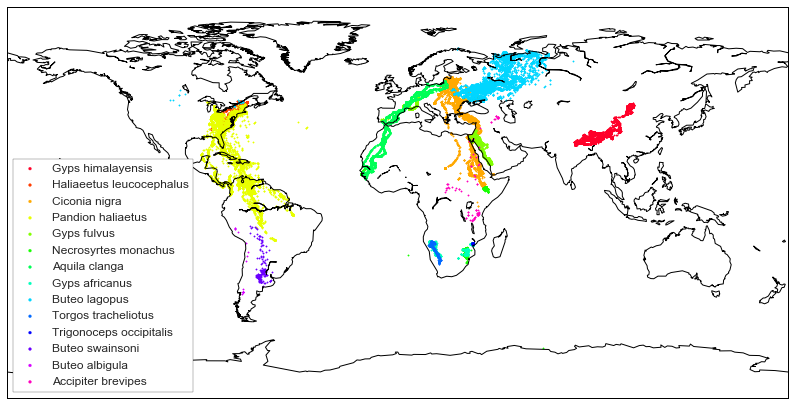

In [5]:
draw_map(df)

## Visualizing a trajectory in 3D

To keep things simple, from now on we'll work a single individual that has nice migration patterns, this is individual `208`. The first thing we're going to do is plot the trajectory through time which will result in a 3D plot with the dimensions being: longitude, latitude, time. The time dimension is normalized to be represented as a number between 0 and 1 where 0 is the first day of the year and 1 is the last.

In [17]:
def plot3d_simple(df):
    #we get a figure object
    fig = plt.figure()
    #we add an Axes3D object to the plot
    ax = fig.add_subplot(111, projection='3d')
    
    #now we can do a scatter plot on the new axes. the c argument colors each point so let's color by time of year
    ax.scatter(df['timeofyear'], df['long'], df['lat'], c=df['timeofyear'])
    
        
    ax.set_xlabel('Time of year')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Latitude')

    plt.show()

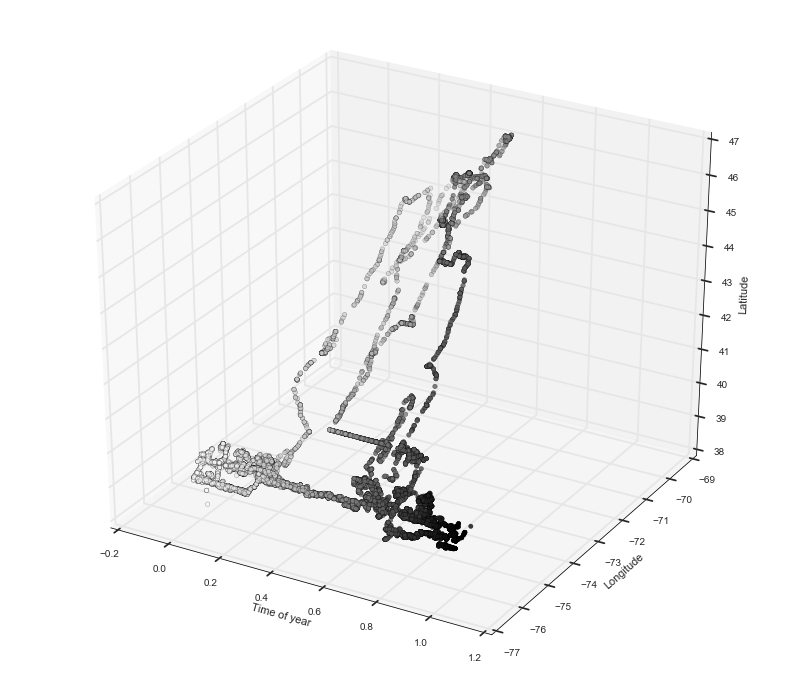

In [16]:
#you can play with the .loc function to plot different species and individuals
d = df.loc[df['tag'] == '208']
plot3d_simple(d)

## Clustering

We can see that this eagle has a very nice migration pattern. Towards the beginning of the year, the eagle is around -75 longitude and 38 latitude. Then around 0.5 of the year it flies north and returns to the same spot but further on in time. We can see that in longitude and latitude there are two concentrated areas which represent its two migration destinations. So let's do something simple to pick these out and use an unsupervised learning technique known as K-means clustering. Since we know that we want two clusters, the K-means algorithm will identify two clusters of points which we can use as the 'home bases' for the eagle. 

Here's a quick overview of how K-means clustering works:

1. Pick $k$ cluster centers $C_i$ at random
2. Assign each data point to the nearest center $C_i$.
3. For each $C_i$ compute a new $C_{i}^{'}$ from the mean of all the points belonging to $C_i$
4. Re-assign the points to the newly computed centers.
5. Repeat until convergence

For more details, there is plenty of literature on this and other clustering algorithms with a quick google search. 

So now that we know how to cluster let's try it on our dataset using `scikit-learn`'s KMeans implementation.

In [60]:
def cluster(df, key, val):
    """
        Takes a dataframe and computs clusters on longitude and latitude.
        Returns a tuple (df, centers) df with new column denoting the cluster ID of each point,
        and the cluster centers.
    """
    
    #scikit takes as input a numpy matrix with numeric values so we need to convert our input dataframe accordingly
    #thankfully pandas has a nice function that lets us convert DataFrame columns to numpy matrices
    
    #get DF with the desired eagle(s)
    s = df.loc[df[key] == val]
    
    df_np = df.as_matrix(columns=['timeofyear', 'long', 'lat'])
    
    #now we can give this data to sickitlearn's KMeans() function.
    #this gives us an object that contains the clustering information such as where the centers are and which points
    #belong to which centers, i.e. labels
    kmeans = KMeans(n_clusters=2).fit(df_np)
    
    #store the labels in new DF column 'cluster'
    s['cluster'] = kmeans.labels_
    
    return s

In [52]:
#now we can cluster our 208 eagle
df, centers = cluster(d, 'tag', '208')
print(centers)

[[  0.47368786 -75.93400598  39.81164254]
 [  0.52355137 -71.68675441  44.84591283]]


To visualize the clustering let's update our 3D plotting function to draw cluster centers and cluster labelling.

In [63]:
def plot3d_cluster(df, labels=np.array([])):
    """
        Now the function will accept two optional arguments: centers, and labels which we will use to visualize
        clustering.
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    if len(labels) > 0:
        ax.scatter(df['timeofyear'], df['long'], df['lat'], c=labels)
    else:
        ax.scatter(df['timeofyear'], df['long'], df['lat'], c=df['timeofyear'])
    
        
    ax.set_xlabel('Time of year')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Latitude')

    plt.show()

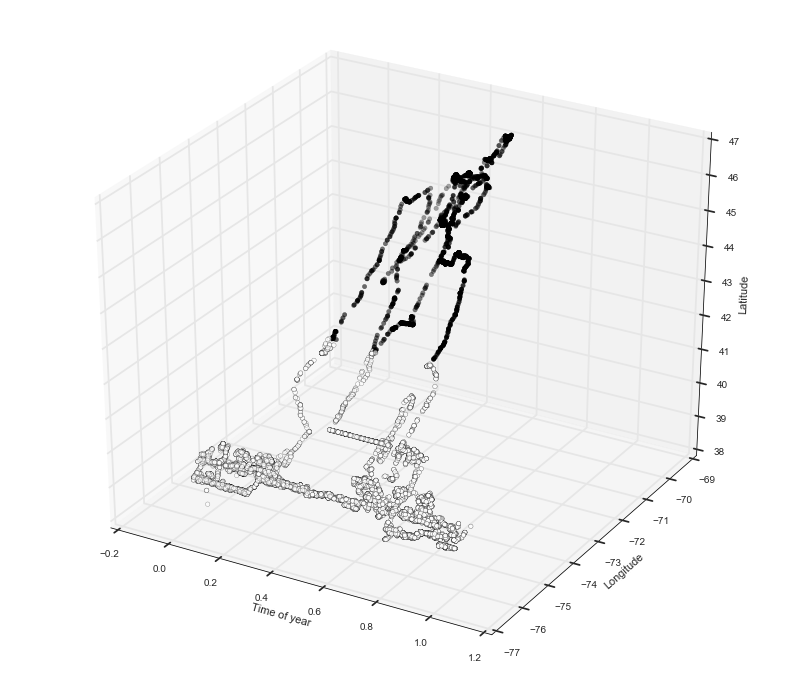

In [64]:
plot3d_cluster(df, labels=df['cluster'])

Okay so we see that K-means did a pretty nice job of separating what seem to be the two home bases. However, this clustering still doesn't tell us which points are in migration and which are 'stationary'. We need to find a way to separate those points around the middle that seem to be moving from those that are concentrated in one of the home bases. We need to find a way to separate these points away.

## Detecting migratory phases 

Let's try something very naïve. Let's assume that if eagles are at their home base, their position can be modelled with a Gaussian distribution where the center of the distribution is the cluster center we identified using K-means. Then, we compare the distance of each point to one of the two gaussian home bases and if an eagle is sufficiently far from either home base we say that it is migrating and 'stationary' otherwise. 

So if we want to model the position of an eagle at a homebase as a gaussian in 2D we will need two parameters: a mean vector ${\bf \mu }= (\mu_{timeofyear},\mu_{longitude}, \mu_{latitude})$ and a covariance matrix $\Sigma$. ${\bf \mu}$ we have from K-means, and $\Sigma$ we can estimate from the data as a matrix of sample variances. 

### Mahalanobis Distance

Now we need a measure of distance between a point and a distribution. For this, we use a metric known as the [Mahalanobis Distance](https://en.wikipedia.org/wiki/Mahalanobis_distance) which in general takes as input a vector to ${\bf x} = (x_1, x_2, .., x_n)^T$, distribution parameters ${\bf \mu} \in \mathbb{R}^n$, and $\Sigma \in \mathbb{R}^{nxn}$ and computes a distance $D_M({\bf x})$ as follows:

$$D_M({\bf x}) = \sqrt{({\bf x} - {\bf \mu)}^T\Sigma^{-1}({\bf x}- {\bf \mu})} $$

Given the distribution parameters, we can apply this function to each of our points to get a measure of how far it is from the distribution center, or 'home base'. Conveniently, the quantity $D_M$ is $\chi^2_{n}$ distributed so we can assign a probability to each point.

In [102]:
def migration(df, key, val):
    #d is the dataframe containing the birds we want to work with
    d = df.loc[df[key] == val]
    
    
    #convert the data to a numpy matrix
    X = d.as_matrix(columns=['timeofyear', 'long', 'lat'])
    #do k-means clustering as before
    kmeans = KMeans(n_clusters=2).fit(X)
    #store labels and centers from clustering
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    #print(centers)
    
    #as before, make new column with cluster ID for each point
    d['kmeans'] = labels
    

    #store parameters for gaussian models for each cluster in a dictionary
    gaussians = {}
    
    #get gaussian model parameters
    for i in range(len(centers)):
        #get datapoints belonging to a cluster
        dd = d.loc[d['kmeans'] == i][['timeofyear', 'long', 'lat']]
        #the mean vector is the same as the cluster center vector
        mu = centers[i]
        #compute the covariance matrix using the pandas function cov() that works on a DataFrame
        cov = dd.cov()
        
        #add the model parameters to the dictionary
        gaussians[i] = (mu, cov)

    #assign each point to migrating or not migrating, store 1 if migrating, 0 else
    mig = []
    
    #go through each datapoint with the itertuples() function which gives us an iterator of the rows in the DF
    #the iterator yields a namedtuple object so we can access columns by name
    for i, eagle in enumerate(d.itertuples()):
        #get the keys of the gaussian dictionary
        models = gaussians.keys()
        #list to store the distance of each point to each cluster [dist_to_cluster_0, dist_to_cluster_1, ..]
        model_distances = []
        for m in models:
            #get the model parameters for the current cluster
            model = gaussians[m]
            #position vector, will be input to mahalanobis distance
            pos_vec = np.array([eagle.timeofyear, eagle.long, eagle.lat])
            #mean vector
            mu_vec = model[0]
            #inverse of covariance matrix which we convert to a numpy matrix
            S_inv = np.linalg.inv(model[1].as_matrix(columns=['timeofyear', 'long', 'lat']))
            #scipy function for computing mahalanobis distance
            mala = mahalanobis(pos_vec, mu_vec, S_inv)
            #store the distance
            model_distances.append(mala)

        #check if distance above threshold of 1.5 which corresponds to a chi2 probability density of 0.68 
        #this means that points with scores greater than 2 to both clusters 
        #will have a probability of 0.52 of belonging to 
        #the cluster. we use a weak threshold because the data is fairly noisy.
        if model_distances[0] >= 2 and model_distances[1] >= 2:
            mig.append(1)
        else:
            mig.append(0)
    
    #store the migration status in a new column of the DataFrame
    d.loc[:,'migration'] = mig
    
    #make 3D plot using the migration status labels we just obtained
    plot3d_cluster(d, labels=d['migration'])
    
    return d

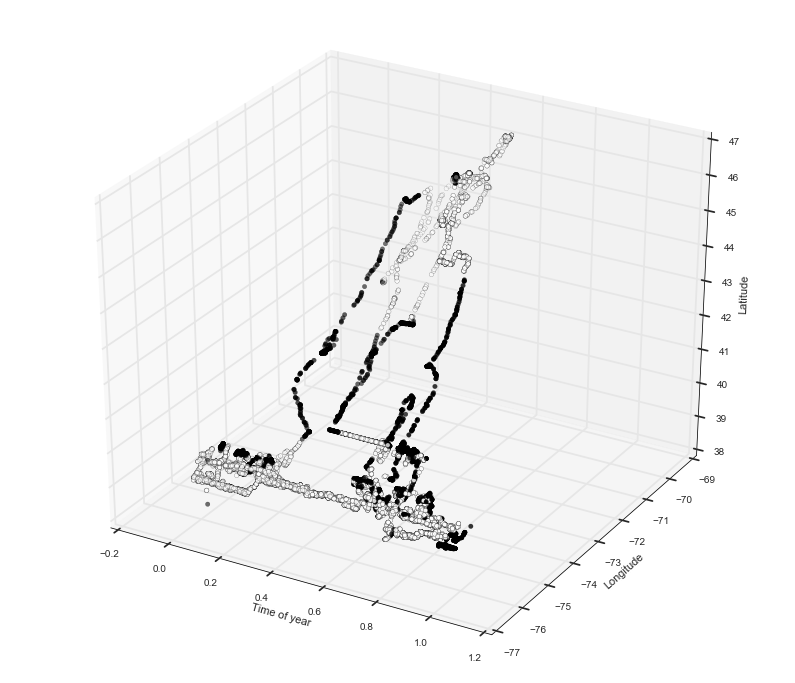

In [103]:
mig = migration(df, 'tag', '208')

Now you can see a nice separation between the points that appear to be in motion and the ones that are at their home base. 

And there you have it!

Hope you enjoyed this notebook. Please feel free to send feedback :)